# Modelling Methane Cleaned Dataset

In [42]:
# Reading cleaned Methane dataset into a dataframe and converting date time column to a datetime format
import pandas as pd
df = pd.read_csv(r'/content/sample_data/methane_data_cleaned.csv')
df['Date Time'] = pd.to_datetime(df['Date_Time'])
df.head()

,Date_Time,Date,Time,Year,DoY,month,Hour,Rg_f,VPD_f,rH_f,Tair_f,Tsoil_f,Methane Turbulent Flux,Date Time
0,5/6/2020 0:00,5/6/2020,0:00,2020,126,5,24.0,1.3,399.4,65.6,18.3,16.0,0.003,2020-05-06 00:00:00
1,5/6/2020 0:30,5/6/2020,0:30,2020,127,5,0.5,1.3,587.9,64.9,18.4,15.6,0.023,2020-05-06 00:30:00
2,5/6/2020 1:00,5/6/2020,1:00,2020,127,5,1.0,0.6,534.4,65.5,18.1,15.5,0.008,2020-05-06 01:00:00
3,5/6/2020 1:30,5/6/2020,1:30,2020,127,5,1.5,0.5,483.3,68.0,17.5,14.8,0.005,2020-05-06 01:30:00
4,5/6/2020 2:00,5/6/2020,2:00,2020,127,5,2.0,1.1,560.6,66.3,17.6,14.7,0.001,2020-05-06 02:00:00


In [43]:
# Dropping unnecessary columns
df = df.drop(columns = ['DoY', 'month', 'Hour', 'Year'])

In [44]:
# Checking for null values in dataframe
df.isnull().any()

Date_Time                 False
Date                      False
Time                      False
Rg_f                      False
VPD_f                     False
rH_f                      False
Tair_f                    False
Tsoil_f                   False
Methane Turbulent Flux    False
Date Time                 False
dtype: bool

In [45]:
len(df)

5271

# ARIMA Model

In [46]:
# Installing pmdarima for modelling
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
# Splitting 80% of data for training and 20% for testing
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

train, test = train_test_split(df, train_size=4262)
# All the independent variables
cols = ["Rg_f", "VPD_f", "rH_f", "Tair_f", 'Tsoil_f']

In [48]:
# Applying ARIMA model
model = auto_arima(train["Methane Turbulent Flux"],
                   exogenous = train[cols],
        trace=True,
        error_action="ignore",
        suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-31898.542, Time=13.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29707.683, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30775.612, Time=2.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31674.476, Time=2.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29709.682, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-31862.766, Time=9.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-31702.746, Time=7.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-31715.815, Time=6.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-31821.804, Time=2.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31715.831, Time=1.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-31829.315, Time=3.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-31578.658, Time=5.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-31824.562, Time=2.87 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-31900.579, Time=4.54 sec
 ARI

In [49]:
# Evaluation on test data
forecast = model.predict(n_periods=len(test),  exogenous=test[cols])

<Axes: >

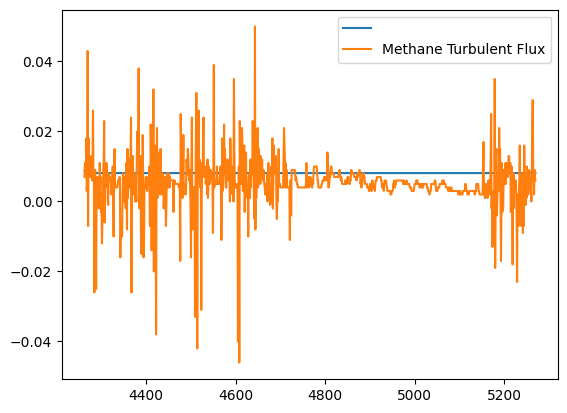

In [50]:
# Plotting predicted vs actual labels
forecast.plot(legend = 'Predicted')
test['Methane Turbulent Flux'].plot(legend = True)

In [51]:
# Evaluation metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
r2 = r2_score(test['Methane Turbulent Flux'], forecast)
mse=mean_squared_error(forecast, test['Methane Turbulent Flux'])
rmse=sqrt(mean_squared_error(forecast, test['Methane Turbulent Flux']))
print('MSE:', mse)
print('RMSE:', rmse)
print('R-SQUARED:', r2)

MSE: 6.199055949682861e-05
RMSE: 0.007873408378639368
R-SQUARED: -0.15916529921078926


# Prophet Model

In [52]:
from prophet import Prophet
model = Prophet()

In [53]:
# Adding all independent variables to the model
for feature in cols:
	model.add_regressor(feature)

In [54]:
df['ds'] = df['Date Time']

In [55]:
df['y'] = df['Methane Turbulent Flux']

In [56]:
df= df.drop(columns = ['Date Time', 'Methane Turbulent Flux'])

In [57]:
# Spiltting 80% data for training and 20% for forecasting
train_p, test_p = train_test_split(df, train_size=4262)
cols = ["Rg_f", "VPD_f", "rH_f", "Tair_f", 'Tsoil_f']

In [58]:
# Training the model
model.fit(train_p[["ds", "y"] + cols])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavm4rb7b/nwbu_9u6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavm4rb7b/kt_wjtv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58170', 'data', 'file=/tmp/tmpavm4rb7b/nwbu_9u6.json', 'init=/tmp/tmpavm4rb7b/kt_wjtv9.json', 'output', 'file=/tmp/tmpavm4rb7b/prophet_modelw21cp_e9/prophet_model-20230512200628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [59]:
# Forecasting the remaining 20% of data
forecast = model.predict(test_p[["ds", "y"] + cols])

In [60]:
# PLotting Actual and Forecasted data 
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

In [62]:
# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_true = test_p['y'].values
y_pred = forecast['yhat'].values

# Calculate RMSE
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('R2 score:', r2)


MSE: 9.316849000986242e-05
MAE: 0.007490661640206218
RMSE: 0.009652382607929631
R2 score: -0.7421633467403159
